In [1]:
import numpy as np
import scipy.optimize as opt
import random

import matplotlib.pyplot as plt

import qiskit.ignis.verification.randomized_benchmarking as rb

import qiskit
from qiskit import assemble, transpile, Aer, execute, IBMQ
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

token = "HAIYAA"
IBMQ.save_account(token, overwrite=True)
provider = IBMQ.load_account()

# A. One-qubit RB simulation

In [2]:
# Generate Clifford Set
sx = np.matrix([[.5+.5j, .5-.5j], [.5-.5j, .5+.5j]])
sy = np.matrix([[.5+.5j, -.5-.5j], [.5+.5j, .5+.5j]])
sz = np.matrix([[1, 0], [0, 0+1j]])
id = np.matrix([[1, 0], [0, 1]])
x  = sx @ sx
y  = sy @ sy
z  = sz @ sz
clifford0 = lambda a, b: [a, a @ b, a @ b @ b, a @ b @ b @ b]
clifford1 = lambda a1, a2, b: clifford0(a1, b) + clifford0(a2, b)
clifford  = clifford1(id, z, sx) + clifford1(sz, sz @ z, sy) + clifford1(sy @ y, sy, sz)
assert(len(clifford) == 24)

# Function simulation rb with length m chain, fadility p, and readout error e
def rb_1q (m, noise_p, readout_e):
    rho = np.matrix([[1, 0], [0, 0]])
    u   = np.identity(2)
    for _ in range(m):
        gate = random.choice(clifford)
        u    = gate @ u
        rho  = gate @ rho @ gate.H
        rho  = noise_p * rho + (1 - noise_p) * np.identity(2) / 2
    u   = np.linalg.inv(u)
    rho = u @ rho @ u.H
    rho = np.array([[1 - readout_e, 0], [0, readout_e]]) @ rho
    return np.real(np.trace(rho))

# The fitting target
exp_with_dc = lambda x, p, a, b: a * np.exp(np.log(p) * x) + b

## 2. RB without readout noise

p = 0.995, A = 0.49999999999999956, B = 0.5


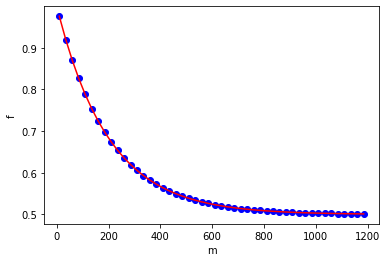

In [3]:
p    = 0.995
e    = 0
rept = 5

ms = range(10, 1200, 25)
fs = []
for m in ms:
    f   = [rb_1q(m, p, e) for _ in range(rept)]
    fs += [np.mean(f)]
    
popt, _ = opt.curve_fit(exp_with_dc, ms, fs, p0=[p, 1, 1])
print(f'p = {popt[0]}, A = {popt[1]}, B = {popt[2]}')
plt.plot(ms, fs, 'bo', ms, exp_with_dc(ms, *popt), 'r-', ms=6)
plt.xlabel('m')
plt.ylabel('f')
plt.show()

## 3. RB without readout noise

p = 0.995, A = 0.4899999999999996, B = 0.5
p = 0.995, A = 0.44999999999999957, B = 0.49999999999999983
p = 0.995, A = 0.39999999999999974, B = 0.5


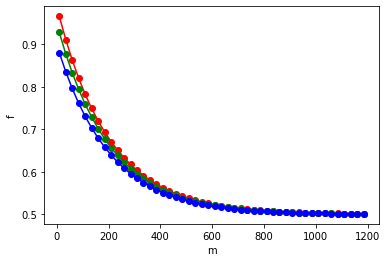

In [4]:
p    = 0.995
es   = [0.01, 0.05, 0.1]
rept = 5

ms   = range(10, 1200, 25)
fss  = []
popt = [0, 0, 0]
for idx, e in enumerate(es):
    fs = []
    for m in ms:
        f   = [rb_1q(m, p, e) for _ in range(rept)]
        fs += [np.mean(f)]
    fss += [fs]

    popt[idx], _ = opt.curve_fit(exp_with_dc, ms, fs, p0=[p, 1, 1])
    print(f'p = {popt[idx][0]}, A = {popt[idx][1]}, B = {popt[idx][2]}')

plt.plot(ms, fss[0], 'ro', ms, exp_with_dc(ms, *popt[0]), 'r-', ms=6)
plt.plot(ms, fss[1], 'go', ms, exp_with_dc(ms, *popt[1]), 'g-', ms=6)
plt.plot(ms, fss[2], 'bo', ms, exp_with_dc(ms, *popt[2]), 'b-', ms=6)
plt.xlabel('m')
plt.ylabel('f')
plt.show()

# B. Two-qubit RB on Qiskit

In [5]:
# Generate RB circuit
nQ      = 2
rb_opts = {}
rb_opts = {'length_vector': [1, 10, 20, 50, 75, 100, 125, 150, 175, 200],
           'nseeds': 5,
           'rb_pattern': [[0, 1]]}
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)
basis_gates     = ['u1', 'u2', 'u3', 'cx']
shots           = 200
simu            = Aer.get_backend('aer_simulator')

In [6]:
def do_rb_simu (p1Q, p2Q):
    # Prepare noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
    noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')
    # Execute RB
    transpiled_circ_list = []
    rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
    for rb_seed, rb_circ_seed in enumerate(rb_circs):
        print(f'Compiling seed {rb_seed}')
        new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
        transpiled_circ_list.append(new_rb_circ_seed)
        print(f'Simlating seed {rb_seed}')
        qobj = assemble(new_rb_circ_seed, shots = shots)
        job = simu.run(qobj, noise_model=noise_model, max_parallel_experinments=0)
        rb_fit.add_data(job.result())
        print('After seed %d, alpha: %f, EPC %f' % (rb_seed, rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))
        rb_fit.plot_rb_data(0, add_label=True, show_plt=False)
    # Compute EPC
    gates_per_cliff = rb.rb_utils.gates_per_clifford(transpiled_circ_list, xdata[0], basis_gates, rb_opts['rb_pattern'][0])
    for basis_gate in basis_gates:
        print('Number of %s gates per Clifford: %f' % (basis_gate, np.mean([gates_per_cliff[0][basis_gate], gates_per_cliff[1][basis_gate]])))
    epgs_1q = {'u1': 0, 'u2': p1Q/2, 'u3': 2 * p1Q/2}
    epgs_2q = p2Q * 3 / 4
    pred_epc = rb.rb_utils.calculate_2q_epc(gate_per_cliff=gates_per_cliff, epg_2q=epgs_2q, qubit_pair=[0, 1], list_epgs_1q=[epgs_1q, epgs_1q])
    print("Predicated 2Q error per clifford: %e" % pred_epc)

In [7]:
def do_rb_real ():
    # Execute RB
    rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
    for rb_seed, rb_circ_seed in enumerate(rb_circs):
        print(f'Run seed {rb_seed}')
        job = execute(rb_circ_seed, provider.get_backend('ibmq_lima'), shots = shots)
        rb_fit.add_data(job.result())
        print('After seed %d, alpha: %f, EPC %f' % (rb_seed, rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))
        rb_fit.plot_rb_data(0, add_label=True, show_plt=False)


## 1. Verify identy

[[ 1.+0.j  0.+0.j -0.+0.j -0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j -0.-0.j]
 [ 0.-0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -0.+0.j  1.+0.j]]


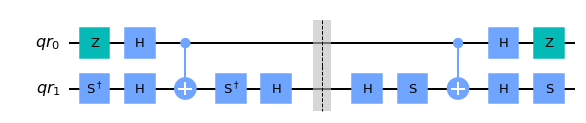

In [8]:
unitary = Aer.get_backend('unitary_simulator')
circ    = rb_circs[0][0].remove_final_measurements(inplace=False)
job     = execute(circ, unitary)

print(job.result().get_unitary(circ, decimals=3))
circ.draw(output = 'mpl')

## 2. RB simulation

Compiling seed 0
Simlating seed 0
After seed 0, alpha: 0.977264, EPC 0.017052


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 1
Simlating seed 1
After seed 1, alpha: 0.982452, EPC 0.013161


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 2
Simlating seed 2
After seed 2, alpha: 0.981029, EPC 0.014228


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 3
Simlating seed 3


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


After seed 3, alpha: 0.979800, EPC 0.015150
Compiling seed 4
Simlating seed 4
After seed 4, alpha: 0.979425, EPC 0.015431


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Number of u1 gates per Clifford: 0.123799
Number of u2 gates per Clifford: 1.642467
Number of u3 gates per Clifford: 0.173581
Number of cx gates per Clifford: 1.489738
Predicated 2Q error per clifford: 1.583893e-02


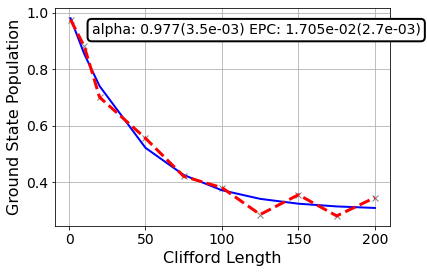

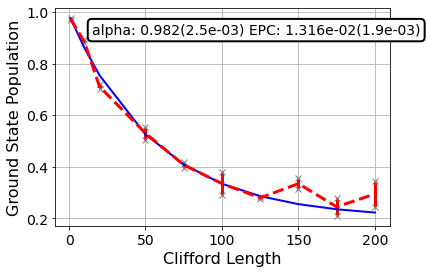

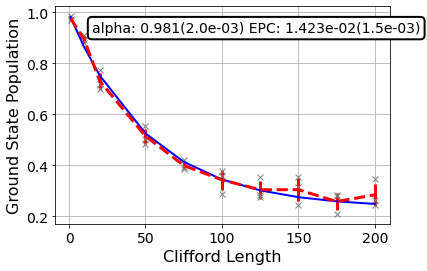

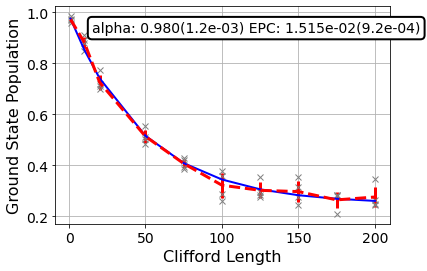

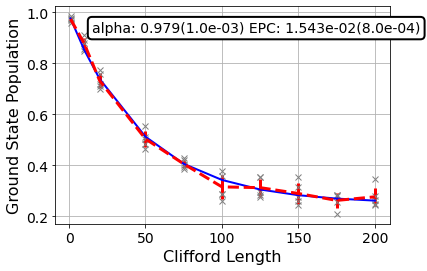

In [9]:
do_rb_simu(0.002, 0.01)

Compiling seed 0
Simlating seed 0
After seed 0, alpha: 0.951157, EPC 0.036632


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 1
Simlating seed 1
After seed 1, alpha: 0.953297, EPC 0.035027


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 2
Simlating seed 2
After seed 2, alpha: 0.955948, EPC 0.033039


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 3
Simlating seed 3
After seed 3, alpha: 0.957099, EPC 0.032176


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 4
Simlating seed 4
After seed 4, alpha: 0.953810, EPC 0.034643


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Number of u1 gates per Clifford: 0.123799
Number of u2 gates per Clifford: 1.642467
Number of u3 gates per Clifford: 0.173581
Number of cx gates per Clifford: 1.489738
Predicated 2Q error per clifford: 3.439642e-02


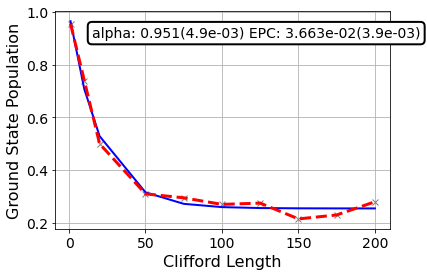

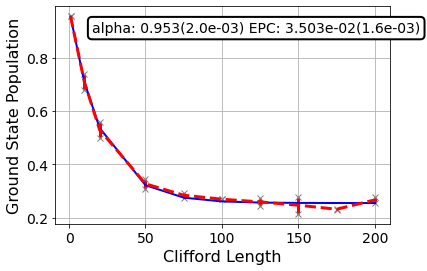

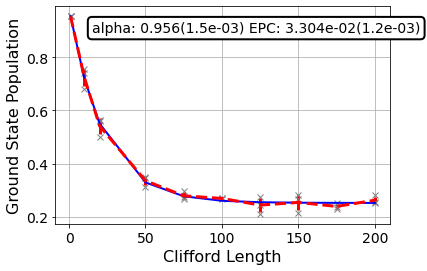

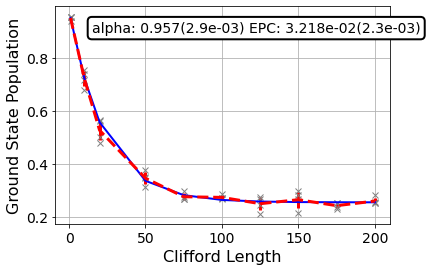

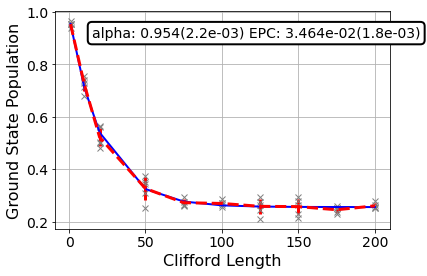

In [10]:
do_rb_simu(0.010, 0.01)

Compiling seed 0
Simlating seed 0
After seed 0, alpha: 0.903842, EPC 0.072119
Compiling seed 1


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Simlating seed 1


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


After seed 1, alpha: 0.912805, EPC 0.065396
Compiling seed 2
Simlating seed 2
After seed 2, alpha: 0.914986, EPC 0.063760


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 3
Simlating seed 3
After seed 3, alpha: 0.918968, EPC 0.060774


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 4
Simlating seed 4
After seed 4, alpha: 0.918635, EPC 0.061024


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Number of u1 gates per Clifford: 0.123799
Number of u2 gates per Clifford: 1.642467
Number of u3 gates per Clifford: 0.173581
Number of cx gates per Clifford: 1.489738
Predicated 2Q error per clifford: 5.958888e-02


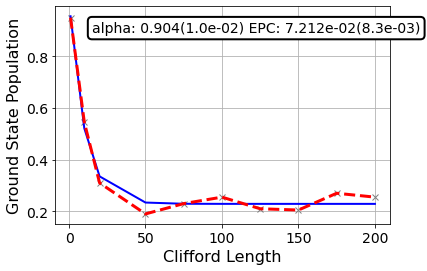

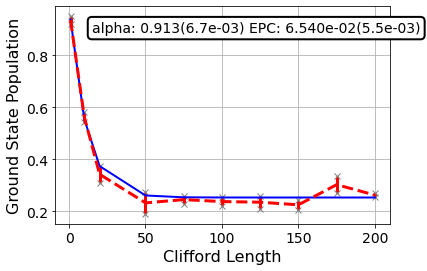

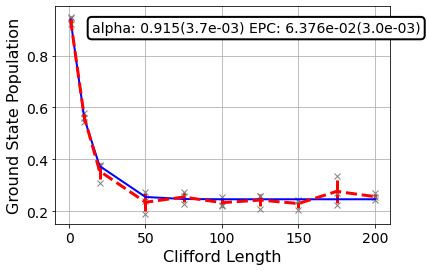

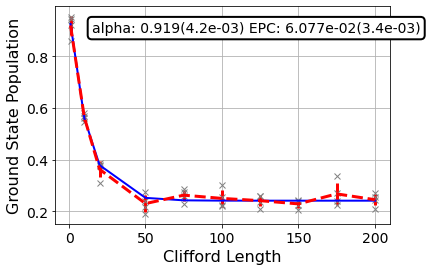

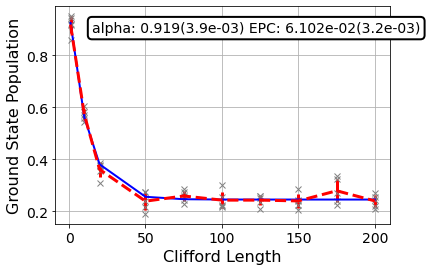

In [11]:
do_rb_simu(0.002, 0.05)

Compiling seed 0
Simlating seed 0
After seed 0, alpha: 0.901525, EPC 0.073857


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 1
Simlating seed 1
After seed 1, alpha: 0.892288, EPC 0.080784


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 2
Simlating seed 2
After seed 2, alpha: 0.891024, EPC 0.081732


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 3
Simlating seed 3
After seed 3, alpha: 0.895554, EPC 0.078335


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 4
Simlating seed 4
After seed 4, alpha: 0.894169, EPC 0.079373


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Number of u1 gates per Clifford: 0.123799
Number of u2 gates per Clifford: 1.642467
Number of u3 gates per Clifford: 0.173581
Number of cx gates per Clifford: 1.489738
Predicated 2Q error per clifford: 7.704050e-02


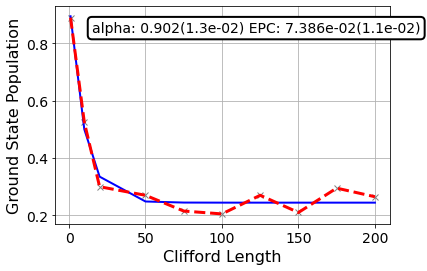

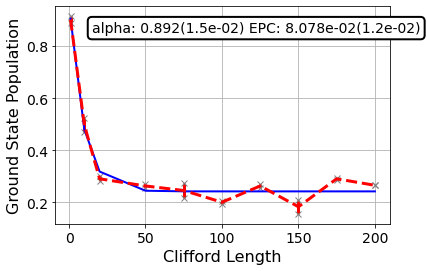

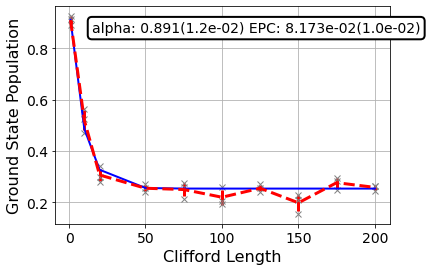

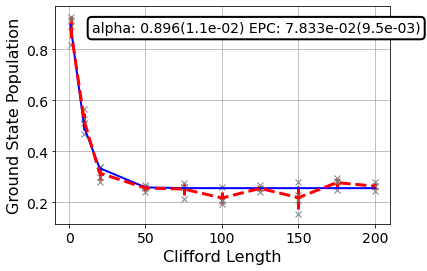

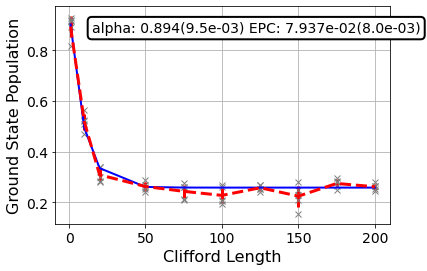

In [12]:
do_rb_simu(0.010, 0.05)

## 3. RB real device

Run seed 0
After seed 0, alpha: 0.989862, EPC 0.007603
Run seed 1
After seed 1, alpha: 0.988681, EPC 0.008489
Run seed 2
After seed 2, alpha: 0.991777, EPC 0.006167
Run seed 3
After seed 3, alpha: 0.990680, EPC 0.006990
Run seed 4
After seed 4, alpha: 0.990561, EPC 0.007079


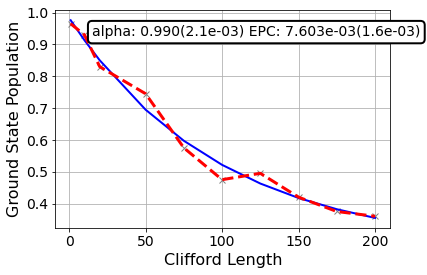

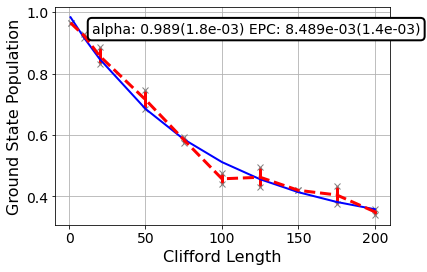

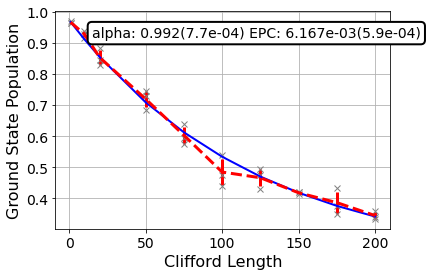

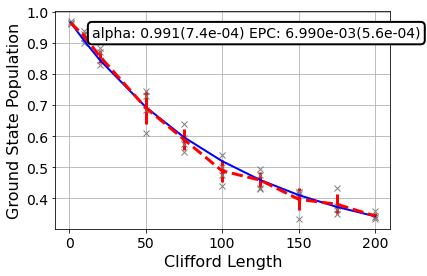

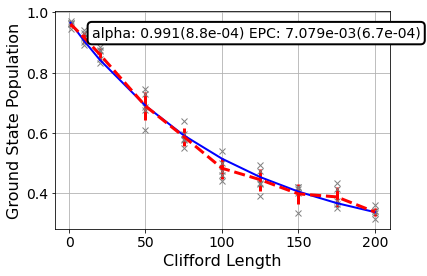

In [13]:
do_rb_real()

# C.Two-qubit RB on Qiskit with thermal relaxation error

In [15]:
def do_rb_T (t1, t2, p1Q, p2Q):
    # Prepare noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,p1Q), 'u2')
    noise_model.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,2*p1Q), 'u3')
    noise_model.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,p2Q).tensor(thermal_relaxation_error(t1,t2,p2Q)), 'cx')    
    # Execute RB
    transpiled_circ_list = []
    rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
    for rb_seed, rb_circ_seed in enumerate(rb_circs):
        print(f'Compiling seed {rb_seed}')
        new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
        transpiled_circ_list.append(new_rb_circ_seed)
        print(f'Simlating seed {rb_seed}')
        qobj = assemble(new_rb_circ_seed, shots = shots)
        job = simu.run(qobj, noise_model=noise_model, max_parallel_experinments=0)
        rb_fit.add_data(job.result())
        print('After seed %d, alpha: %f, EPC %f' % (rb_seed, rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))
        rb_fit.plot_rb_data(0, add_label=True, show_plt=False)
    # Compute EPC
    gates_per_cliff = rb.rb_utils.gates_per_clifford(transpiled_circ_list, xdata[0], basis_gates, rb_opts['rb_pattern'][0])
    for basis_gate in basis_gates:
        print('Number of %s gates per Clifford: %f' % (basis_gate, np.mean([gates_per_cliff[0][basis_gate], gates_per_cliff[1][basis_gate]])))
    u2_error = rb.rb_utils.coherence_limit(1,[t1],[t2],p1Q)
    u3_error = rb.rb_utils.coherence_limit(1,[t1],[t2],2*p1Q)
    epg_2q = rb.rb_utils.coherence_limit(2,[t1,t1],[t2,t2],p2Q)
    epgs_1q = {'u1': 0, 'u2': u2_error, 'u3': u3_error}
    pred_epc = rb.rb_utils.calculate_2q_epc(
        gate_per_cliff=gates_per_cliff,
        epg_2q=epg_2q,
        qubit_pair=[0, 1],
        list_epgs_1q=[epgs_1q, epgs_1q])
    print("Predicted 2Q Error per Clifford: %e"%pred_epc)

Compiling seed 0
Simlating seed 0
After seed 0, alpha: 0.984113, EPC 0.011915


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 1
Simlating seed 1
After seed 1, alpha: 0.983318, EPC 0.012511


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 2
Simlating seed 2
After seed 2, alpha: 0.983769, EPC 0.012174


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 3
Simlating seed 3
After seed 3, alpha: 0.982706, EPC 0.012970


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Compiling seed 4
Simlating seed 4
After seed 4, alpha: 0.982226, EPC 0.013331


/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Number of u1 gates per Clifford: 0.123799
Number of u2 gates per Clifford: 1.642467
Number of u3 gates per Clifford: 0.173581
Number of cx gates per Clifford: 1.489738
Predicted 2Q Error per Clifford: 1.309264e-02


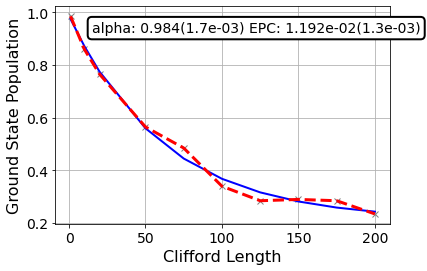

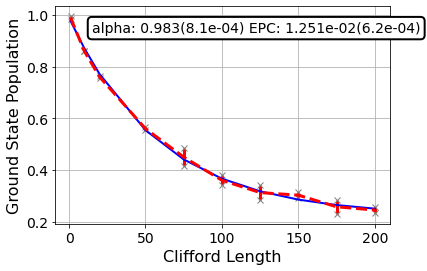

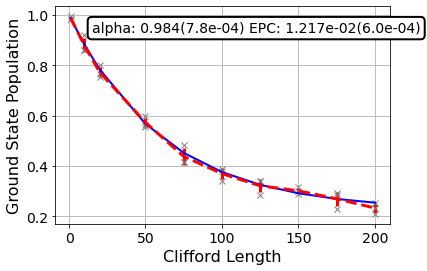

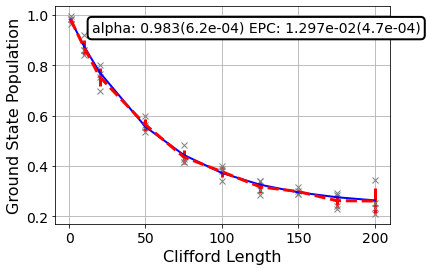

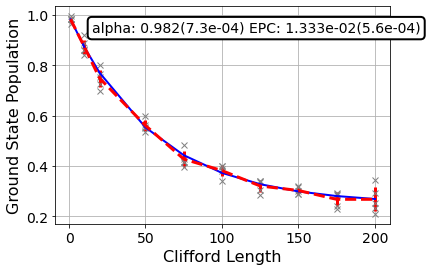

In [16]:
do_rb_T(100, 80, 0.1, 0.5)